In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import datetime
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl

import seaborn as sns
sns.set_style("darkgrid")

# Introduction

In this notebook we explore the influence on the North American League of Legends ranked bottom lane (ADC) community by Doublelift's video regarding why some ADC's should be taking Ghost as their non-flash summoner spells. This analysis/notebook will follow this format:

1. Getting and cleaning the data.
2. Plotting Doublelift's influence on players taking Ghost.
3. Doing some time series analysis on our data

# Getting and Cleaning Data
Here we get our data from files that I have downloaded at a previous time from Riot's API. You can completely ignore this next cell and you won't lose any insights from this project.

For documentation on how I data mined, don't be afraid to ask. However, I'm sure there's lots of ways you can get data that are probably more efficient than how I got mine.

In [3]:
# We are essentially looping over each file which contains all matches from a specific player:
# for each of these matches we append to a list the time, bot players' summoner spells, win/loss information, 
# and bot players' champions.

times = []
match_ids = []
p1_ghost = []
p1_champ = []
p1_WL = []
p2_ghost = []
p2_champ = []
p2_WL = []

files_path = "puuid_data_files/"
for filename in os.listdir(files_path):
    with open(files_path + filename) as f:
        #print (filename) #troubleshooting
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            continue
        for key in data.keys():
            #print (key) #troubleshooting
            if len(data[key]["bot_sums"]) == 2 and len(data[key]) == 4:
                match_ids.append(key)
                times.append(data[key]["time"])
                p1_champ.append(data[key]["champions"][0])
                p1_WL.append(data[key]["win_loss"][0])
                p2_champ.append(data[key]["champions"][1])
                p2_WL.append(data[key]["win_loss"][1])
                if 6 in data[key]["bot_sums"][0]: #Summoner Spell 6 is ghost
                    p1_ghost.append(True)
                else: 
                    p1_ghost.append(False)

                if 6 in data[key]["bot_sums"][1]:
                    p2_ghost.append(True)
                else: 
                    p2_ghost.append(False)

In [4]:
#Here we take the lists that were appended above and turn them into a dataframe to use pandas on
df = pd.DataFrame(index = match_ids,
                  data = {"times" : times, "p1_ghost" : p1_ghost, "p2_ghost" : p2_ghost,
                          "p1_champ" : p1_champ, "p1_WL" : p1_WL, "p2_champ" : p2_champ,
                          "p2_WL" : p2_WL}
                  )
df["times"] = pd.to_datetime(df["times"], unit = "s") #turn dates to datetime object
df = df.drop_duplicates() #Need to drop because a lot of games are repeated due to my shitty data-mining algorithm
df["day"] = df["times"].dt.date # Create a column identifying the specific day the match took place on
print (f"There are {len(df)} data points") #Printing the length of the df

There are 58641 data points


# Data Analysis
In the cells above we created a dataframe where each row represents data from a specific match. Now we want to aggregate our data into a dataframe such that each row represents data for a given day.

The data in each column will represent for each day:
1. How many bot players took Ghost (["p1_ghost"]["sum"] + ["p2_ghost"]["sum"])
2. How many total bot players there were in total (["p2_ghost"]["count"])
3. The percentage of bot players who took Ghost each day ((["p1_ghost"]["sum"] + ["p2_ghost"]["sum"])/(2*["p2_ghost"]["count"]))

In [5]:
df_days = df.groupby("day").agg({"p1_ghost" : 'sum', "p2_ghost" : ['sum','count'],
                                 "p1_WL" : "sum", "p2_WL" : "sum"})
df_days["ghost_percent"] = (df_days["p1_ghost"]["sum"] + df_days["p2_ghost"]["sum"])/(2*df_days["p2_ghost"]["count"])
df_days = df_days.asfreq("d") #This line makes it so we can use time series statistics later

Before we plot, let's make sure we have enough data to draw insights from. We will plot the amount of games per day that I was able to get from my algorithm.

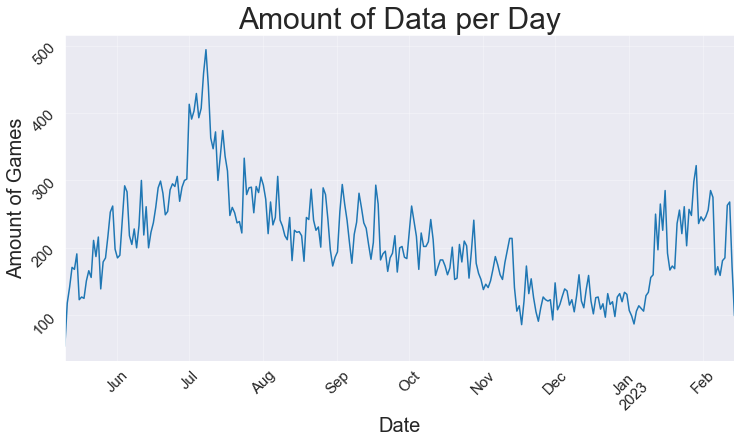

In [6]:
df_days["p2_ghost"]["count"].plot(figsize = (12,6))
plt.xlabel("Date",fontsize = 20)
plt.ylabel("Amount of Games",fontsize = 20)
plt.title("Amount of Data per Day", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15, rotation = 45)
plt.grid(alpha = .4)

It seems like there are at least about 100 games for each day. If you're wondering why there appears to be a trend in amount of game data per day, that's because there probably is. I'd assume looking at this data that in the summer months there are more young players staying home due to summer break from school and playing video games. The opposite happens in the winter. If we look at previous years and/or other games and compare this type of data to those, then we may be able to draw some conclusions. However, for now let's stick to completing this project.

**It seems that the beginning and final days for this data have far fewer points than the others. This is due to the fact that I didn't specify my data gathering algorithm to get data from the beginning of the first day and end of the last day. This was a small mistake, but it doesn't matter because we can just remove these data points from our set.**

In [7]:
df_days = df_days[~df_days.index.isin(df_days.iloc[[0,-1],].index)] #there's probably an easier way todo this

Now we can plot the percentage of bot players over time who took ghost as a summoner spell. We will also plot the date when Doublelift uploaded his video regarding this topic.  

<ipython-input-8-068c55f64dcb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


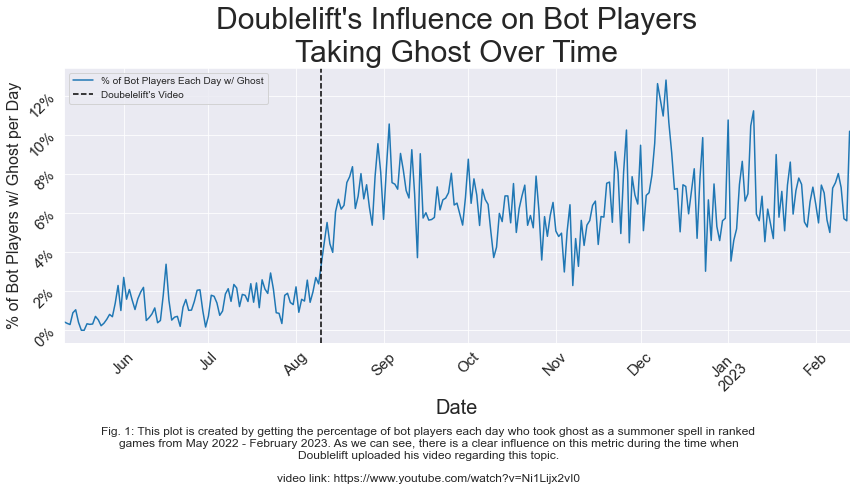

In [8]:
df_days["ghost_percent"].plot(figsize = (12,6), label = "% of Bot Players Each Day w/ Ghost")


plt.axvline(x = datetime.datetime.strptime("2022-08-10", "%Y-%m-%d"), ls = '--', c = 'black',
            label = "Doubelelift's Video")
plt.xlabel("Date",fontsize = 20)
plt.ylabel("% of Bot Players w/ Ghost per Day",fontsize = 16)
plt.title("Doublelift's Influence on Bot Players\nTaking Ghost Over Time", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15, rotation = 45)
plt.legend()
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
#plt.grid(alpha = .4)
txt="Fig. 1: This plot is created by getting the percentage of bot players each day who took ghost as a summoner spell in ranked\ngames from May 2022 - February 2023. As we can see, there is a clear influence on this metric during the time when\nDoublelift uploaded his video regarding this topic.\n\nvideo link: https://www.youtube.com/watch?v=Ni1Lijx2vI0"
plt.figtext(0.5, -0.12, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.savefig("Doublelift_Influence.png", bbox_inches='tight')
plt.show()

**This plot shows for each day, the percentage of bot players that took ghost as a summoner spell from May 11, 2022 to February 13, 2023.** The vertical line is the date when Doublelift uploaded his video regarding why some ADC's should be taking ghost over the other non-flash summoner spells.

As we can see, there is a clear upwards trend in the percentage of bot players who took ghost right around the time when Doublelift uploaded his video. I can't say that this video is the cause of the upwards trend because there could be other influences that caused this trend. However, after searching through YouTube, Reddit and Twitter for content promoting ghost as a summoner spell, I couldn't find anything that had a substantial amount of viewers/media presence. **This leads me to believe that this video is the major influence behind this trend.**

# Time Series Analysis: Decomposition
Here we split up the plot above into its time series components:
1. Trend Component (Does the overall plot go up or down)
2. Seasonal Component (Cyclical patterns in the data)
3. Residual Component (Random Effects)

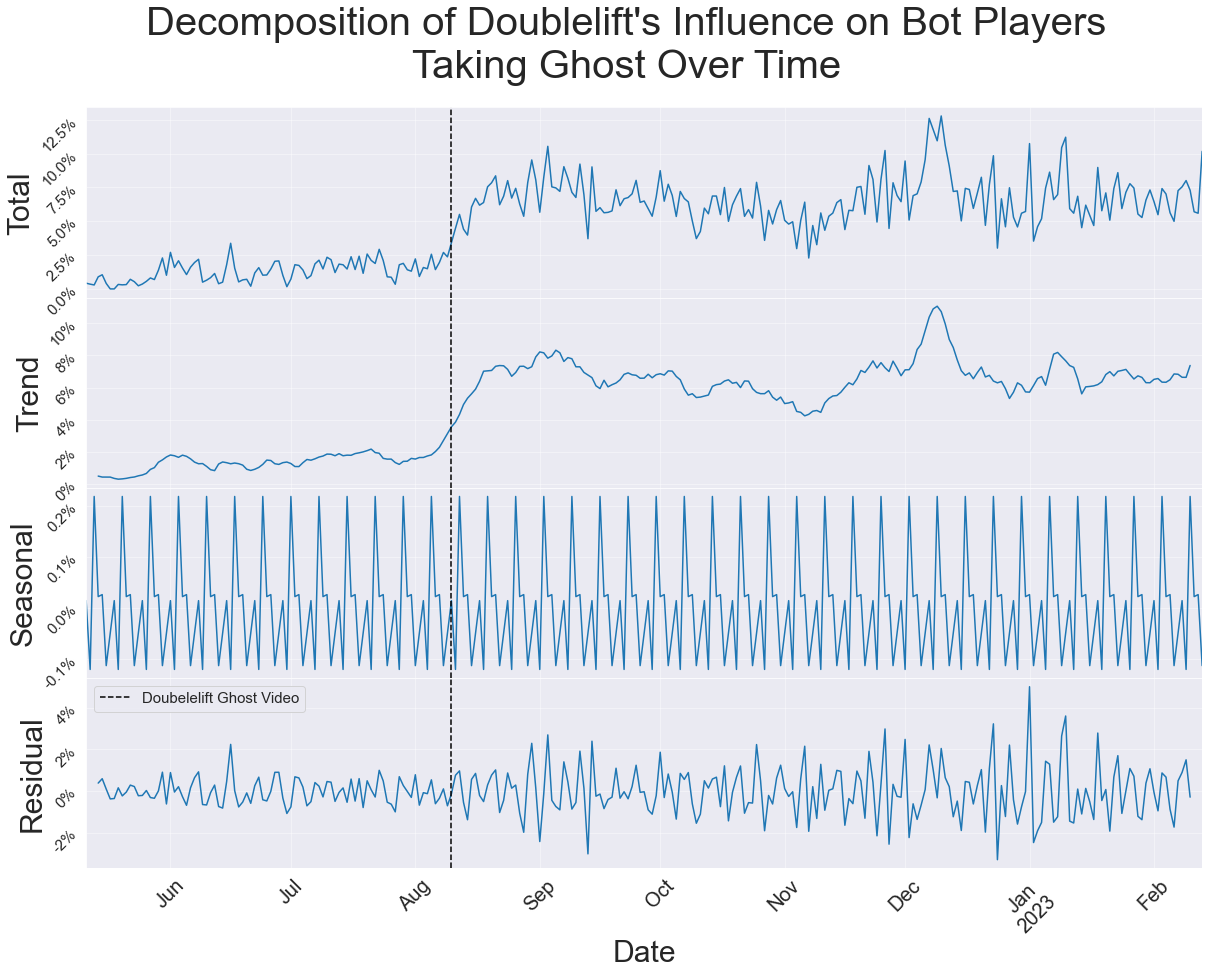

In [9]:
s_dec_add = seasonal_decompose(df_days["ghost_percent"], model = "additive")

fig, axs = plt.subplots(nrows = 4, figsize = (20,14), sharex=True)

s_dec_add.observed.plot(ax = axs[0])
axs[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
axs[0].tick_params(axis = "y", labelsize = 15, labelrotation=45)
axs[0].set_ylabel("Total", fontsize = 30) 
axs[0].axvline(x = datetime.datetime.strptime("2022-08-10", "%Y-%m-%d"), ls = '--', c = 'black',
            label = "Doubelelift Ghost Video")


s_dec_add.trend.plot(ax = axs[1])
axs[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
axs[1].tick_params(axis = "y", labelsize = 15, labelrotation=45)
axs[1].set_ylabel("Trend", fontsize = 30)
axs[1].axvline(x = datetime.datetime.strptime("2022-08-10", "%Y-%m-%d"), ls = '--', c = 'black',
            label = "Doubelelift Ghost Video")

s_dec_add.seasonal.plot(ax = axs[2])
axs[2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
axs[2].tick_params(axis = "y", labelsize = 15, labelrotation=45)
axs[2].set_ylabel("Seasonal", fontsize = 30) 
axs[2].axvline(x = datetime.datetime.strptime("2022-08-10", "%Y-%m-%d"), ls = '--', c = 'black',
            label = "Doubelelift Ghost Video")

s_dec_add.resid.plot(ax = axs[3], label = "_nolegend_")
axs[3].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
axs[3].tick_params(axis = "y", labelsize = 15, labelrotation=45)
axs[3].set_ylabel("Residual", fontsize = 30) 
axs[3].tick_params(axis = "x", labelsize = 20, labelrotation=45)
axs[3].set_xlabel("Date", fontsize = 30) 
axs[3].axvline(x = datetime.datetime.strptime("2022-08-10", "%Y-%m-%d"), ls = '--', c = 'black',
            label = "Doubelelift Ghost Video")

plt.subplots_adjust(wspace=0, hspace=0)
axs[0].grid(alpha = .5)
axs[1].grid(alpha = .5)
axs[2].grid(alpha = .5)
axs[3].grid(alpha = .5)

fig.suptitle("Decomposition of Doublelift's Influence on Bot Players\nTaking Ghost Over Time", fontsize=40)
plt.legend(loc = "upper left", fontsize = 15)
plt.savefig("Doublelift_Influence_Decomposition.png")
plt.show()

We can see that the trend is definitely going up near the data when Doublelift uploaded his video. However, it seems to be going up right before he uploads this. I'm not really sure what could explain this. This could just be that players were seeing Doublelift and other high level players taking ghost and mimicking that playstyle leading up to the video. There needs to be more analysis into this.

# Other Goals of This Project
I also have data regarding whether bot laners won/lost and their champions played. I could further the data analysis utilizing this data, however the point of this project was to determine if Doublelift had some sort of influence on the bot player community. I believe I answered this question with: 

**Yes, Doublelift's video influenced North American bot players to take ghost from about 1-2% of the time to 4-10% of the time in ranked games.**